# Imports

In [2]:
import random as rand
from collections import Counter
import random
import csv
import math
from matplotlib import pyplot as plt
import pandas as pd #Sólo para visualizar rápidamente diccionarios ( lo dicta el sentido común :-) )

# Funcion para la importacion de los datasets

In [3]:
def get_data_set_from_csv(filename, delimeter):
    data_set = {}
    with open(filename) as f:
        reader = csv.reader(f, delimiter=delimeter)
        read_keys = False
        keys = []
        for row in reader:
            if not read_keys:
                for key in row:
                    data_set[key] = []
                    keys.append(key)
                read_keys = True
            else:
                for i,key in enumerate(keys):
                    if row[i] == '':
                        data_set[key].append(None)
                    else:
                        data_set[key].append(row[i])
    return data_set

Importamos el dataset.

**Limpieza**: no incluimos las variables *Name, Cabin, Fare, Ticket* ni *PassangerId*, al no considerarlas relevantes. Las que si se incluyen son: *Survived, Pclass, Sex, Age, SibSp, Parch*.

Discretizamos *Age* en *Young*, *Adult* y *Old*.

Reemplazamos los faltantes en age por el rango etario modico, *Adult* y por *S* en Embarked (de incluirla).

Incluiriamos variables como Embarked? No son relevantes **causalmente** al momento de saber si alguien sobrevivio o no. Pero el evento del hundimiento del Titanic es historicamente singular. No se trata de un fenomeno estocastico que interese predecir a futuro como la bolsa de acciones o el estilo literario de un periodista. Por ejemplo, por pura casualidad podria haber pasado que la mayoria de los pasajeros que embarcaron por S sobrevivieron. En ese caso la variable pasaria a ser relevante (me encantaria saber el puerto de embarque si es tan decisivo, aunque no haya causalidad involucrada). Pero no podemos dejar de pensar en la causalidad con respecto a esas variables "irrelevantes". Por ejemplo, quizas el puerto es decisivo porque alli solo embarcaron pasajeros de primera clase.

In [4]:
data_set = get_data_set_from_csv('titanic.csv', '\t')
unimportant_keys = ['Ticket', 'Name', 'PassengerId', 'Cabin', 'Fare']
for key in unimportant_keys:
    data_set.pop(key, None)

#Discretizacion: joven, adulto, viejo
for i in range(len(data_set['Survived'])):
    if data_set['Age'][i] == None:
        continue
    if float(data_set['Age'][i]) <= 18:
        data_set['Age'][i] = 'Young'
    elif float(data_set['Age'][i]) <= 60:
        data_set['Age'][i] = 'Adult'
    else:
        data_set['Age'][i] = 'Old'
    
df = pd.DataFrame.from_dict(data_set)
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
count,156,156,156,126,156,156,155
unique,2,3,2,3,6,5,3
top,0,3,male,Adult,0,0,S
freq,102,96,100,95,98,121,110


In [5]:
for i in range(len(data_set['Survived'])):
    if data_set['Age'][i] == None:
        data_set['Age'][i] = 'Adult'
    if data_set['Embarked'][i] == None:
        data_set['Embarked'][i] = 'S'

df = pd.DataFrame.from_dict(data_set)
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

In [6]:
def get_attributes(data_set):
    ret = {}
    for key in data_set.keys():
        ret[key] = set(data_set[key])
    return ret
attributes = get_attributes(data_set)
attributes

{'Survived': {'0', '1'},
 'Pclass': {'1', '2', '3'},
 'Sex': {'female', 'male'},
 'Age': {'Adult', 'Old', 'Young'},
 'SibSp': {'0', '1', '2', '3', '4', '5'},
 'Parch': {'0', '1', '2', '3', '5'},
 'Embarked': {'C', 'Q', 'S'}}

# Ejercicio 1

La funcion `get_attribute_dictionary` recibe el dataset y un atributo. Retorna un diccionario, donde las claves son '1' y '0'. A su vez, a cada clave le corresponde otro diccionario, de forma tal que:

diccionario['1'/'0'] es un diccionario que contiene como claves a los posibles valores del atributo de entrada y como valores correspondientes a la probabilidad condicional de observar ese valor del atributo dado que el registro corresponde a un sobreviviente o a un no sobreviviente.

Este diccionario es usado en el calculo de la ganancia.

In [7]:
def entropy_term(probability):
    if probability == 0:
        return 0
    return probability * math.log(probability)

def get_attribute_dictionary(data_set, output_var, attribute):
    ret = {}
    ret['1'], ret['0'] = {}, {}
    total_p, total_n = 0, 0
    for i in range(len(data_set[output_var])):
        if data_set[output_var][i] == '1':
            if data_set[attribute][i] not in ret['1'].keys():
                ret['1'][data_set[attribute][i]] = 1
            else:
                ret['1'][data_set[attribute][i]] += 1
            total_p += 1
        else:
            if data_set[attribute][i] not in ret['0'].keys():
                ret['0'][data_set[attribute][i]] = 1
            else:
                ret['0'][data_set[attribute][i]] += 1
            total_n += 1
    total = total_p + total_n
    for key in ret['1'].keys():
        ret['1'][key] /= total_p
    for key in ret['0'].keys():
        ret['0'][key] /= total_n
        
    for key in ret['1']:
        if key not in ret['0']:
            ret['0'][key] = 0
    for key in ret['0']:
        if key not in ret['1']:
            ret['1'][key] = 0
    
    ret['pos_prob'] = total_p / total
    ret['neg_prob'] = total_n / total
    return ret

def get_gain(data_set, output_var, attribute):
    attribute_dict = get_attribute_dictionary(data_set, output_var, attribute)
    #Entropy for output_var
    ret = -entropy_term(attribute_dict['pos_prob']) - \
            entropy_term(attribute_dict['neg_prob'])
    #Remaining terms
    for key in attribute_dict['1'].keys():
        total_attribute_prob = attribute_dict['1'][key] * attribute_dict['pos_prob'] + attribute_dict['0'][key] * attribute_dict['neg_prob']
        positive_given_attribute = attribute_dict['1'][key] * attribute_dict['pos_prob'] / total_attribute_prob
        negative_given_attribute = attribute_dict['0'][key] * attribute_dict['neg_prob'] / total_attribute_prob

        aux = total_attribute_prob
        aux *= (-entropy_term(positive_given_attribute)-entropy_term(negative_given_attribute))
        
        ret -= aux
    return ret

print(get_attribute_dictionary(data_set, 'Survived', 'Sex'))
print(get_gain(data_set, 'Survived', 'Sex'))
print(get_gain(data_set, 'Survived', 'Pclass'))

{'1': {'female': 0.7407407407407407, 'male': 0.25925925925925924}, '0': {'male': 0.8431372549019608, 'female': 0.1568627450980392}, 'pos_prob': 0.34615384615384615, 'neg_prob': 0.6538461538461539}
0.1706777320146992
0.011268886075242068


In [8]:
class Node:
    def __init__(self, attribute, attr_values):
        self.dict = {}
        self.name = attribute
        self.final = False
        for val in attr_values:
            self.dict[val] = None
    
    @classmethod
    def final_node(cls, classification):
        ret = Node('', [])
        ret.final = True
        ret.classification = classification
        return ret

class DecisionTree:
    def __init__(self):
        self.nodes = 0
        self.height = 0
        self.root = None

    @classmethod
    def build_full_tree(cls, data_set, output_var, attributes):
        dTree = DecisionTree()
        dTree.root = DecisionTree.build_full_tree_rec(data_set, output_var, 0, dTree, attributes)
        return dTree
    
    @classmethod
    def build_full_tree_rec(cls, data_set, output_var, height, dTree, attributes):
        #Check if every example is positive or negative
        num_equals = len(list(filter(lambda x : x == '1', data_set[output_var])))
        if num_equals == len(data_set[output_var]) or num_equals == 0:
            ret = Node.final_node(data_set[output_var][0])
            ret.height = height
            if height > dTree.height:
                dTree.height = height
            return ret
        #Check if all attributes have been used
        if len(data_set.keys()) == 1:
            ret = Node.final_node('1' if num_equals > len(data_set[output_var])/2 else '0')
            ret.height = height
            if height > dTree.height:
                dTree.height = height
            return ret
        #Get highest-gain attribute
        winner = None
        max_gain = 0
        for attribute in data_set.keys() - [output_var]:
            gain = get_gain(data_set, output_var, attribute)
            if max_gain <= gain or (max_gain == 0 and abs(gain) < 1e-5):
                winner = attribute
                max_gain = gain
        attr_vals = attributes[winner]
        ret = Node(winner, attr_vals)
        ret.classification = '1' if num_equals >= len(data_set[output_var])/2 else '0'
        ret.height = height
        #Build new data sets
        new_data_sets = {}
        for key in attr_vals:
            new_data_sets[key] = {}
            for key1 in data_set.keys() - [output_var, winner]:
                new_data_sets[key][key1] = []
            new_data_sets[key][output_var] = []
                
        for i in range(len(data_set[output_var])):
            for key in data_set.keys() - [output_var, winner]:
                new_data_sets[data_set[winner][i]][key].append(data_set[key][i])
            new_data_sets[data_set[winner][i]][output_var].append(data_set[output_var][i])
            
        #Build the subtrees
        for attr_name in ret.dict.keys():
            if len(new_data_sets[attr_name][output_var]) == 0:
                ret.dict[attr_name] = Node.final_node('1' if num_equals > len(data_set[output_var])/2 else '0')
                ret.dict[attr_name].height = ret.height + 1
                if ret.height + 1 > dTree.height:
                    dTree.height = ret.height + 1
            else:
                ret.dict[attr_name] = DecisionTree.build_full_tree_rec(new_data_sets[attr_name], output_var, height + 1, dTree, attributes)
        
        return ret

    def print_tree(self):
        self._print_tree_rec(self.root, 0)
    
    def _print_tree_rec(self, node, height):
        if node.final:
            print()
            print('\t'*(height+1)+node.classification)
            return
        print(node.name)
        for key in node.dict.keys():
            print('\t'*(height+1)+key+':', end='')
            self._print_tree_rec(node.dict[key], height+1)
        return

    def classify(self, example):
        found_class = False
        curr_node = self.root
        while not found_class:
            curr_node = curr_node.dict[example[curr_node.name]]
            if curr_node.final:
                found_class = True
        return curr_node.classification

    def classify_max_height(self, example, max_height):
        found_class = False
        curr_node = self.root
        while not found_class:
            if curr_node.height >= max_height or curr_node.final:
                found_class = True
            else:
                curr_node = curr_node.dict[example[curr_node.name]]
        return curr_node.classification

In [9]:
dTree = DecisionTree.build_full_tree(data_set, 'Survived', attributes)
dTree.print_tree()
example = {
    'Sex': 'female',
    'Pclass': '1',
    'Age': 'Old',
    'Embarked': 'Q',
    'SibSp': '0',
    'Parch': '0',
    'Embarked':'C',
    'Fare': '8.05'
}
print(dTree.height)
print(dTree.classify_max_height(example, 0))

Sex
	male:SibSp
		1:Embarked
			C:Pclass
				1:
					0
				2:
					0
				3:Parch
					1:
						1
					5:
						1
					0:Age
						Old:
							0
						Adult:
							0
						Young:
							1
					2:
						1
					3:
						1
			Q:
				0
			S:
				0
		5:
			0
		0:Age
			Old:
				0
			Adult:Embarked
				C:Parch
					1:Pclass
						1:
							0
						2:
							0
						3:
							0
					5:
						0
					0:Pclass
						1:
							0
						2:
							0
						3:
							0
					2:
						0
					3:
						0
				Q:
					0
				S:Parch
					1:
						0
					5:
						0
					0:Pclass
						1:
							0
						2:
							0
						3:
							0
					2:
						0
					3:
						0
			Young:Parch
				1:
					0
				5:
					0
				0:
					0
				2:
					1
				3:
					0
		4:
			0
		2:
			0
		3:
			0
	female:Pclass
		1:
			1
		2:SibSp
			1:Age
				Old:
					1
				Adult:Parch
					1:
						1
					5:
						1
					0:Embarked
						C:
							1
						Q:
							1
						S:
							1
					2:
						1
					3:
						1
				Young:
					1
			5:
			

In [10]:
def random_indices(length, fraction):
    indices = list(range(length))
    random.shuffle(indices)
    partition = int(length*fraction)
    return indices[0:partition], indices[partition:]

def divide_test_train(data_set, output_var, fraction):
    ready = False
    while not ready:
        ready = True
        train, test = random_indices(len(data_set[output_var]), fraction)
        ret_train, ret_test = {}, {}
        for key in data_set.keys():
            ret_train[key] = []
            ret_test[key] = []
        for i in train:
            for key in data_set.keys():
                ret_train[key].append(data_set[key][i])
        for i in test:
            for key in data_set.keys():
                ret_test[key].append(data_set[key][i])
    return ret_train, ret_test

def create_example(i, data_set):
    ret = {}
    for key in data_set.keys():
        ret[key] = data_set[key][i]
    return ret

def get_precision_max_height(dTree, data_set):
    correct = 0
    for i in range(len(data_set['Survived'])):
        example = create_example(i, data_set)
        if dTree.classify(example) == example['Survived']:
            correct += 1
    return correct/len(data_set['Survived'])

def get_precision(dTree, data_set, height):
    correct = 0
    for i in range(len(data_set['Survived'])):
        example = create_example(i, data_set)
        if dTree.classify_max_height(example, height) == example['Survived']:
            correct += 1
    return correct/len(data_set['Survived'])

def get_precision_points(dTree, train, test):
    x_points = list(range(dTree.height + 1))
    y_points_test = []
    y_points_train = []
    for height in x_points:
        y_points_test.append(get_precision(dTree, test, height))
        y_points_train.append(get_precision(dTree, train, height))
    return x_points, y_points_train, y_points_test


In [11]:
def get_random_element(data_set, size):
    ret = {}
    index = rand.choice(range(size))
    for key in data_set.keys():
        ret[key] = data_set[key][index]
    return ret

def new_sample_from(data_set, size):
    ret = {}
    for key in data_set.keys():
        ret[key] = []
    for i in range(size):
        random_element = get_random_element(data_set, size)
        for key in random_element.keys():
            ret[key].append(random_element[key])
    return ret

def get_random_forest(data_set, num_trees, output_var, attributes, num_examples):
    forest = []
    for i in range(num_trees):
        sample = new_sample_from(data_set, num_examples)
        forest.append(DecisionTree.build_full_tree(sample, 'Survived', attributes))
    return forest

def get_forest_confusion_matrix(forest, test_set, output_var):
    ret = {}
    ret['Positive'] = {
        'Positive': 0,
        'Negative': 0
    }
    ret['Negative'] = {
        'Positive': 0,
        'Negative': 0
    }
    for i in range(len(test_set[output_var])):
        votes_p, votes_n = 0, 0
        example = create_example(i, test_set)
        for tree in forest:
            classification = tree.classify(example)
            if classification == '1':
                votes_p += 1
            else:
                votes_n += 1
        positive_example = True if votes_p > votes_n else False
        if positive_example:
            if example[output_var] == '1':
                ret['Positive']['Positive'] += 1
            else:
                ret['Positive']['Negative'] += 1
        else:
            if example[output_var] == '1':
                ret['Negative']['Positive'] += 1
            else:
                ret['Negative']['Negative'] += 1
    return ret

def get_tree_confusion_matrix(tree, test_set, output_var):
    ret = {}
    ret['Positive'] = {
        'Positive': 0,
        'Negative': 0
    }    
    ret['Negative'] = {
        'Positive': 0,
        'Negative': 0
    }
    for i in range(len(test_set[output_var])):
        example = create_example(i, test_set)
        classification = tree.classify(example)
        if classification == example[output_var]:
            if classification == '1':
                ret['Positive']['Positive'] += 1
            else:
                ret['Negative']['Negative'] += 1
        else:
            if classification == '1':
                ret['Positive']['Negative'] += 1
            else:
                ret['Negative']['Positive'] += 1
    return ret

In [12]:
train, test = divide_test_train(data_set, 'Survived', 0.8)
print(len(train['Survived']))
print(len(test['Survived']))

124
32


In [13]:
dTree = DecisionTree.build_full_tree(train, 'Survived', attributes)

pd.DataFrame(get_tree_confusion_matrix(dTree, test, 'Survived'))

,Positive,Negative
Positive,5,9
Negative,1,17


In [14]:
num_trees = 40
forest = get_random_forest(train, num_trees, 'Survived', attributes, len(train['Survived']))
pd.DataFrame(get_forest_confusion_matrix(forest, test, 'Survived'))

,Positive,Negative
Positive,6,8
Negative,1,17


In [15]:
print('Accuracy del arbol entero en el conjunto de entrenamiento: ' + str(get_precision_max_height(dTree, train)))
print('Accuracy del arbol entero en el conjunto de prueba: ' + str(get_precision_max_height(dTree, test)))
x, y_train, y_test = get_precision_points(dTree, train, test)

x_points = list(range(1,num_trees + 1))
y_train_f, y_test_f = [], []
for num_trees in x_points:
    matrix = get_forest_confusion_matrix(forest[0:num_trees], test, 'Survived')
    total = matrix['Positive']['Positive'] + matrix['Positive']['Negative'] + matrix['Negative']['Positive'] + matrix['Negative']['Negative']
    correct = matrix['Positive']['Positive'] + matrix['Negative']['Negative']
    y_test_f.append(correct/total)
    matrix = get_forest_confusion_matrix(forest[0:num_trees], train, 'Survived')
    total = matrix['Positive']['Positive'] + matrix['Positive']['Negative'] + matrix['Negative']['Positive'] + matrix['Negative']['Negative']
    correct = matrix['Positive']['Positive'] + matrix['Negative']['Negative']
    y_train_f.append(correct/total)

Accuracy del arbol entero en el conjunto de entrenamiento: 0.9193548387096774
Accuracy del arbol entero en el conjunto de prueba: 0.6875


0.6875
0.71875


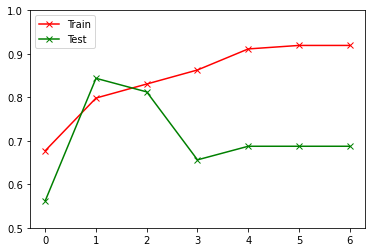

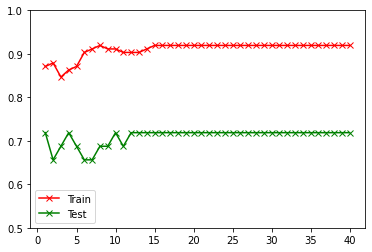

In [16]:
fig1, ax1 = plt.subplots()
plt.ylim(0.5, 1.0)
ax1.plot(x, y_train, '-x', color='red')
ax1.plot(x, y_test, '-x', color='green')
print(y_test[-1])
ax1.legend(['Train', 'Test'])

fig2, ax2 = plt.subplots()
plt.ylim(0.5, 1.0)
ax2.plot(x_points, y_train_f, '-x', color='red')
ax2.plot(x_points, y_test_f, '-x', color='green')
print(y_test_f[-1])
ax2.legend(['Train', 'Test'])